## Chapter 8: Integrating Learning and Planning

### Model-based Reinforcement Learning

In this chapter, we focus on RL algorithms that focus on learning **model** from experiences, and use it to construct value function or policy. 

RL algorithms that mentioned in previous chapters are **model-free RL**: it directly learns value function and(or) policy. 

And there exists **model-based RL**: it learns model from experience, and plan value function and(or) policy from model.

### What is a Model?

A *Model* $\mathcal{M}$ is a representation of an MDP <$\mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}$> parametrized by $\eta$. Assuming we know state space $\mathcal{S}$ and action space $\mathcal{A}$, a model $<\mathcal{P}, \mathcal{R}>$ can represent transitions
</br>
</br>
<font size="3">
$$\begin{align}
S_{t+1} \sim \mathcal{P}_\eta(S_{t+1}|S_t, A_t) \\
R_{t+1} \sim \mathcal{R}_\eta(R_{t+1}|S_t, A_t)
\end{align}$$
</font>

model $<\mathcal{P}, \mathcal{R}>$ is learned from experience ${S_1, A_1, R_2, ... , S_T}$.

Model can be parametrized in various ways: from lookup table models to deep neural networks.

For example, lookup table models  can be constructed from experiences as the following:
</br>
</br>
<font size="3">
$$\begin{align}
\hat{\mathcal{P}}_{s, s'}^a = \dfrac{1}{N(s, a)} \sum_{t=1}^T \mathbb{1}(S_t, A_t, S_{t+1} = s, a, s') \\
\hat{\mathcal{R}}_{s}^a = \dfrac{1}{N(s, a)} \sum_{t=1}^T \mathbb{1}(S_t, A_t = s, a)R_t 
\end{align}$$
</font>

where $N(s, a)$ is a visit count to each state-action pair $(s,a)$.

If the model is accurate, then we can learn value function or policy from experiences sampled from the model. Yet if not, learning from simulated experience can lead to sub-optimal policy.

### Integrating Planning, Acting and Learning

Dyna-Q algorithm is a reinforcement learning algorithm that learns value function and(or) policy from both simulated experiences from **model** and **real-world experiences**. Dyna-Q uses real-world experiment to build model, and uses model to generate simulated experiences.

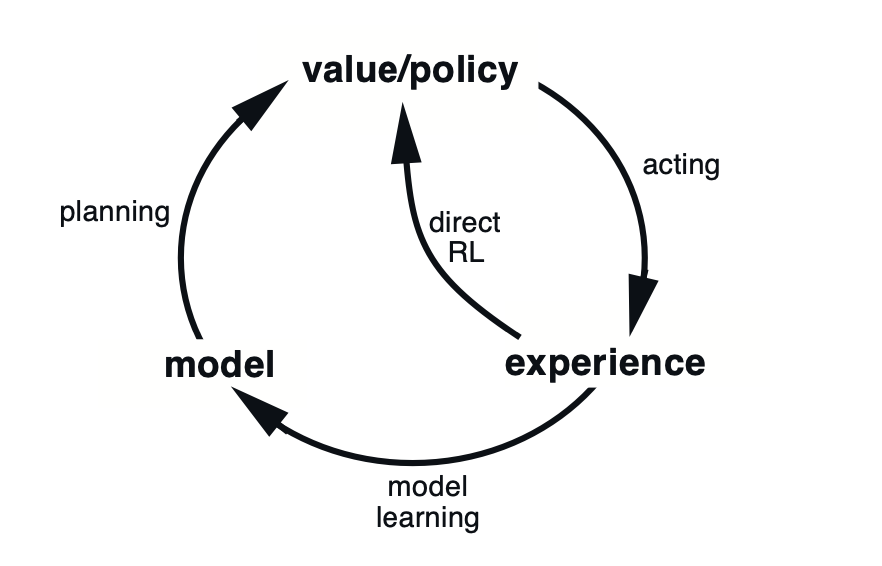 

Learning from both direct experiences and simulated experiences can help improving sample efficiency.


In [1]:
import gymnasium as gym
import matplotlib
import IPython
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from utils import JupyterRender

%matplotlib inline

/opt/anaconda3/envs/rl/lib/python3.6/site-packages/gymnasium/core.py:27: UserWarning: WARN: Gymnasium minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gymnasium minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [2]:
class Dyna_Q:
    def __init__(self, env, gamma=0.8, alpha=0.1, model_n=10, eps=0.1, render=False):
        self.env = env
        self.state_dim = env.observation_space.n
        self.action_dim = env.action_space.n
        
        self.gamma = gamma
        self.alpha = alpha
        self.model_n = model_n
        self.eps = eps
        
        self.q = np.zeros([self.state_dim, self.action_dim]) # q-value
        self.model_r = np.zeros([self.state_dim, self.action_dim]) # reward model
        self.model_ns = np.zeros([self.state_dim, self.action_dim]) # transition model
        
    def action(self, s):
        #epsilon-greedy action
        if np.random.random() < self.eps:
            action = np.random.randint(low=0, high=self.action_dim - 1)
        else:
            action = np.argmax(self.q[s,:])

        return action
    
    def run(self):
        states = []
        actions = []
        success = 0

        for episode in range(10000):
            observation, _ = env.reset()
            done = False
            episode_reward = 0
            local_step = 0
            
            while not done:
                action = self.action(observation)
                next_observation, reward, done, _, _ = env.step(action)
                if reward == 0:
                    reward = -0.001
                if done and next_observation != 15:
                    reward = -1
                episode_reward += reward
                local_step += 1
                self.q[observation, action] = self.q[observation, action] + self.alpha*(reward + self.gamma*np.max(self.q[next_observation, :]) - self.q[observation, action])
                #self.q[observation, action] = self.q[observation, action] + self.alpha*(reward + self.gamma*np.max(self.q[next_observation,:]) - self.q[observation, action])

                self.model_r[observation, action] = reward
                self.model_ns[observation, action] = next_observation

                states.append(observation)
                actions.append(action)

                observation = next_observation
                

            if episode >= 100:
                for _ in range(self.model_n):
                    sample = np.random.randint(low=0, high=len(states) - 1)
                    s = states[sample]
                    a = actions[sample]

                    r= (self.model_r[s, a])
                    ns = int(self.model_ns[s, a])
                    self.q[s, a] = self.q[s,a] + self.alpha*(r + self.gamma*np.max(self.q[ns,:]) - self.q[s,a])

            print("Episode: {}, Step: {}, Episode_reward: {}".format(episode, local_step, episode_reward))
            if episode_reward >=0:
                success += 1
                
        print("Success: ", success)
        print(self.q)
        print(self.model_r)
        print(self.model_ns)
    

In [3]:
env = gym.make("FrozenLake-v1", render_mode='rgb_array', is_slippery=False)#define the environment.
env = JupyterRender(env)

config = {
    'env': env,
    'gamma': 0.8,
    'alpha': 0.1,
    'model_n': 10,
    'eps': 0.1,
    'render': False
}

a = Dyna_Q(**config)
a.run()

Episode: 0, Step: 6, Episode_reward: -1.005
Episode: 1, Step: 6, Episode_reward: -1.005
Episode: 2, Step: 2, Episode_reward: -1.001
Episode: 3, Step: 14, Episode_reward: -1.013
Episode: 4, Step: 7, Episode_reward: -1.006
Episode: 5, Step: 5, Episode_reward: -1.004
Episode: 6, Step: 13, Episode_reward: -1.012
Episode: 7, Step: 11, Episode_reward: -1.01
Episode: 8, Step: 7, Episode_reward: -1.006
Episode: 9, Step: 11, Episode_reward: -1.01
Episode: 10, Step: 15, Episode_reward: 0.986
Episode: 11, Step: 8, Episode_reward: -1.007
Episode: 12, Step: 22, Episode_reward: -1.021
Episode: 13, Step: 9, Episode_reward: -1.008
Episode: 14, Step: 18, Episode_reward: 0.983
Episode: 15, Step: 31, Episode_reward: 0.97
Episode: 16, Step: 17, Episode_reward: -1.016
Episode: 17, Step: 9, Episode_reward: 0.992
Episode: 18, Step: 14, Episode_reward: 0.987
Episode: 19, Step: 2, Episode_reward: -1.001
Episode: 20, Step: 14, Episode_reward: 0.987
Episode: 21, Step: 12, Episode_reward: 0.989
Episode: 22, Step:

Episode: 744, Step: 7, Episode_reward: 0.994
Episode: 745, Step: 6, Episode_reward: 0.995
Episode: 746, Step: 3, Episode_reward: -1.002
Episode: 747, Step: 3, Episode_reward: -1.002
Episode: 748, Step: 6, Episode_reward: 0.995
Episode: 749, Step: 6, Episode_reward: 0.995
Episode: 750, Step: 6, Episode_reward: 0.995
Episode: 751, Step: 6, Episode_reward: 0.995
Episode: 752, Step: 6, Episode_reward: 0.995
Episode: 753, Step: 6, Episode_reward: 0.995
Episode: 754, Step: 6, Episode_reward: 0.995
Episode: 755, Step: 6, Episode_reward: 0.995
Episode: 756, Step: 6, Episode_reward: 0.995
Episode: 757, Step: 6, Episode_reward: 0.995
Episode: 758, Step: 6, Episode_reward: 0.995
Episode: 759, Step: 5, Episode_reward: -1.004
Episode: 760, Step: 6, Episode_reward: 0.995
Episode: 761, Step: 6, Episode_reward: 0.995
Episode: 762, Step: 6, Episode_reward: 0.995
Episode: 763, Step: 6, Episode_reward: 0.995
Episode: 764, Step: 6, Episode_reward: 0.995
Episode: 765, Step: 6, Episode_reward: 0.995
Episode

Episode: 1369, Step: 6, Episode_reward: 0.995
Episode: 1370, Step: 6, Episode_reward: 0.995
Episode: 1371, Step: 6, Episode_reward: 0.995
Episode: 1372, Step: 7, Episode_reward: 0.994
Episode: 1373, Step: 6, Episode_reward: 0.995
Episode: 1374, Step: 6, Episode_reward: 0.995
Episode: 1375, Step: 6, Episode_reward: 0.995
Episode: 1376, Step: 6, Episode_reward: 0.995
Episode: 1377, Step: 6, Episode_reward: 0.995
Episode: 1378, Step: 6, Episode_reward: 0.995
Episode: 1379, Step: 6, Episode_reward: 0.995
Episode: 1380, Step: 6, Episode_reward: 0.995
Episode: 1381, Step: 6, Episode_reward: 0.995
Episode: 1382, Step: 2, Episode_reward: -1.001
Episode: 1383, Step: 7, Episode_reward: 0.994
Episode: 1384, Step: 6, Episode_reward: 0.995
Episode: 1385, Step: 6, Episode_reward: 0.995
Episode: 1386, Step: 6, Episode_reward: 0.995
Episode: 1387, Step: 6, Episode_reward: 0.995
Episode: 1388, Step: 6, Episode_reward: 0.995
Episode: 1389, Step: 6, Episode_reward: 0.995
Episode: 1390, Step: 6, Episode_r

Episode: 1969, Step: 8, Episode_reward: 0.993
Episode: 1970, Step: 6, Episode_reward: 0.995
Episode: 1971, Step: 6, Episode_reward: 0.995
Episode: 1972, Step: 6, Episode_reward: 0.995
Episode: 1973, Step: 7, Episode_reward: 0.994
Episode: 1974, Step: 8, Episode_reward: 0.993
Episode: 1975, Step: 2, Episode_reward: -1.001
Episode: 1976, Step: 6, Episode_reward: 0.995
Episode: 1977, Step: 6, Episode_reward: 0.995
Episode: 1978, Step: 6, Episode_reward: 0.995
Episode: 1979, Step: 6, Episode_reward: 0.995
Episode: 1980, Step: 6, Episode_reward: 0.995
Episode: 1981, Step: 6, Episode_reward: 0.995
Episode: 1982, Step: 7, Episode_reward: 0.994
Episode: 1983, Step: 6, Episode_reward: 0.995
Episode: 1984, Step: 7, Episode_reward: 0.994
Episode: 1985, Step: 3, Episode_reward: -1.002
Episode: 1986, Step: 6, Episode_reward: 0.995
Episode: 1987, Step: 7, Episode_reward: 0.994
Episode: 1988, Step: 6, Episode_reward: 0.995
Episode: 1989, Step: 6, Episode_reward: 0.995
Episode: 1990, Step: 6, Episode_

Episode: 2588, Step: 6, Episode_reward: 0.995
Episode: 2589, Step: 6, Episode_reward: 0.995
Episode: 2590, Step: 7, Episode_reward: 0.994
Episode: 2591, Step: 6, Episode_reward: 0.995
Episode: 2592, Step: 6, Episode_reward: -1.005
Episode: 2593, Step: 6, Episode_reward: 0.995
Episode: 2594, Step: 6, Episode_reward: 0.995
Episode: 2595, Step: 6, Episode_reward: 0.995
Episode: 2596, Step: 6, Episode_reward: 0.995
Episode: 2597, Step: 6, Episode_reward: 0.995
Episode: 2598, Step: 6, Episode_reward: 0.995
Episode: 2599, Step: 6, Episode_reward: 0.995
Episode: 2600, Step: 6, Episode_reward: 0.995
Episode: 2601, Step: 6, Episode_reward: 0.995
Episode: 2602, Step: 6, Episode_reward: 0.995
Episode: 2603, Step: 6, Episode_reward: 0.995
Episode: 2604, Step: 7, Episode_reward: 0.994
Episode: 2605, Step: 6, Episode_reward: 0.995
Episode: 2606, Step: 6, Episode_reward: 0.995
Episode: 2607, Step: 8, Episode_reward: 0.993
Episode: 2608, Step: 10, Episode_reward: 0.991
Episode: 2609, Step: 6, Episode_

Episode: 3190, Step: 5, Episode_reward: -1.004
Episode: 3191, Step: 7, Episode_reward: 0.994
Episode: 3192, Step: 8, Episode_reward: 0.993
Episode: 3193, Step: 2, Episode_reward: -1.001
Episode: 3194, Step: 6, Episode_reward: 0.995
Episode: 3195, Step: 6, Episode_reward: -1.005
Episode: 3196, Step: 6, Episode_reward: 0.995
Episode: 3197, Step: 8, Episode_reward: 0.993
Episode: 3198, Step: 8, Episode_reward: 0.993
Episode: 3199, Step: 6, Episode_reward: 0.995
Episode: 3200, Step: 6, Episode_reward: 0.995
Episode: 3201, Step: 7, Episode_reward: 0.994
Episode: 3202, Step: 6, Episode_reward: 0.995
Episode: 3203, Step: 6, Episode_reward: 0.995
Episode: 3204, Step: 6, Episode_reward: 0.995
Episode: 3205, Step: 6, Episode_reward: 0.995
Episode: 3206, Step: 3, Episode_reward: -1.002
Episode: 3207, Step: 6, Episode_reward: 0.995
Episode: 3208, Step: 6, Episode_reward: 0.995
Episode: 3209, Step: 6, Episode_reward: 0.995
Episode: 3210, Step: 6, Episode_reward: 0.995
Episode: 3211, Step: 7, Episod

Episode: 3820, Step: 6, Episode_reward: 0.995
Episode: 3821, Step: 8, Episode_reward: 0.993
Episode: 3822, Step: 6, Episode_reward: 0.995
Episode: 3823, Step: 7, Episode_reward: 0.994
Episode: 3824, Step: 6, Episode_reward: 0.995
Episode: 3825, Step: 8, Episode_reward: 0.993
Episode: 3826, Step: 3, Episode_reward: -1.002
Episode: 3827, Step: 6, Episode_reward: -1.005
Episode: 3828, Step: 6, Episode_reward: 0.995
Episode: 3829, Step: 7, Episode_reward: 0.994
Episode: 3830, Step: 6, Episode_reward: 0.995
Episode: 3831, Step: 6, Episode_reward: 0.995
Episode: 3832, Step: 6, Episode_reward: 0.995
Episode: 3833, Step: 6, Episode_reward: 0.995
Episode: 3834, Step: 3, Episode_reward: -1.002
Episode: 3835, Step: 6, Episode_reward: 0.995
Episode: 3836, Step: 6, Episode_reward: 0.995
Episode: 3837, Step: 6, Episode_reward: 0.995
Episode: 3838, Step: 6, Episode_reward: 0.995
Episode: 3839, Step: 6, Episode_reward: 0.995
Episode: 3840, Step: 6, Episode_reward: 0.995
Episode: 3841, Step: 6, Episode

Episode: 4419, Step: 6, Episode_reward: 0.995
Episode: 4420, Step: 3, Episode_reward: -1.002
Episode: 4421, Step: 6, Episode_reward: 0.995
Episode: 4422, Step: 6, Episode_reward: 0.995
Episode: 4423, Step: 6, Episode_reward: 0.995
Episode: 4424, Step: 6, Episode_reward: 0.995
Episode: 4425, Step: 6, Episode_reward: 0.995
Episode: 4426, Step: 7, Episode_reward: 0.994
Episode: 4427, Step: 6, Episode_reward: 0.995
Episode: 4428, Step: 6, Episode_reward: 0.995
Episode: 4429, Step: 7, Episode_reward: 0.994
Episode: 4430, Step: 6, Episode_reward: 0.995
Episode: 4431, Step: 6, Episode_reward: 0.995
Episode: 4432, Step: 6, Episode_reward: 0.995
Episode: 4433, Step: 6, Episode_reward: 0.995
Episode: 4434, Step: 6, Episode_reward: 0.995
Episode: 4435, Step: 6, Episode_reward: 0.995
Episode: 4436, Step: 8, Episode_reward: 0.993
Episode: 4437, Step: 6, Episode_reward: 0.995
Episode: 4438, Step: 6, Episode_reward: 0.995
Episode: 4439, Step: 6, Episode_reward: 0.995
Episode: 4440, Step: 6, Episode_r

Episode: 4967, Step: 6, Episode_reward: 0.995
Episode: 4968, Step: 8, Episode_reward: 0.993
Episode: 4969, Step: 6, Episode_reward: 0.995
Episode: 4970, Step: 6, Episode_reward: 0.995
Episode: 4971, Step: 6, Episode_reward: 0.995
Episode: 4972, Step: 8, Episode_reward: 0.993
Episode: 4973, Step: 6, Episode_reward: 0.995
Episode: 4974, Step: 6, Episode_reward: 0.995
Episode: 4975, Step: 6, Episode_reward: 0.995
Episode: 4976, Step: 6, Episode_reward: 0.995
Episode: 4977, Step: 6, Episode_reward: 0.995
Episode: 4978, Step: 6, Episode_reward: 0.995
Episode: 4979, Step: 6, Episode_reward: 0.995
Episode: 4980, Step: 6, Episode_reward: 0.995
Episode: 4981, Step: 6, Episode_reward: 0.995
Episode: 4982, Step: 6, Episode_reward: 0.995
Episode: 4983, Step: 7, Episode_reward: 0.994
Episode: 4984, Step: 2, Episode_reward: -1.001
Episode: 4985, Step: 9, Episode_reward: 0.992
Episode: 4986, Step: 6, Episode_reward: 0.995
Episode: 4987, Step: 6, Episode_reward: 0.995
Episode: 4988, Step: 6, Episode_r

Episode: 5556, Step: 6, Episode_reward: 0.995
Episode: 5557, Step: 6, Episode_reward: 0.995
Episode: 5558, Step: 6, Episode_reward: 0.995
Episode: 5559, Step: 6, Episode_reward: 0.995
Episode: 5560, Step: 6, Episode_reward: 0.995
Episode: 5561, Step: 6, Episode_reward: 0.995
Episode: 5562, Step: 7, Episode_reward: 0.994
Episode: 5563, Step: 7, Episode_reward: 0.994
Episode: 5564, Step: 6, Episode_reward: 0.995
Episode: 5565, Step: 6, Episode_reward: 0.995
Episode: 5566, Step: 6, Episode_reward: 0.995
Episode: 5567, Step: 6, Episode_reward: 0.995
Episode: 5568, Step: 6, Episode_reward: 0.995
Episode: 5569, Step: 7, Episode_reward: 0.994
Episode: 5570, Step: 6, Episode_reward: 0.995
Episode: 5571, Step: 6, Episode_reward: 0.995
Episode: 5572, Step: 6, Episode_reward: 0.995
Episode: 5573, Step: 6, Episode_reward: 0.995
Episode: 5574, Step: 6, Episode_reward: 0.995
Episode: 5575, Step: 6, Episode_reward: 0.995
Episode: 5576, Step: 6, Episode_reward: 0.995
Episode: 5577, Step: 6, Episode_re

Episode: 6170, Step: 6, Episode_reward: 0.995
Episode: 6171, Step: 6, Episode_reward: 0.995
Episode: 6172, Step: 6, Episode_reward: 0.995
Episode: 6173, Step: 6, Episode_reward: 0.995
Episode: 6174, Step: 7, Episode_reward: 0.994
Episode: 6175, Step: 6, Episode_reward: 0.995
Episode: 6176, Step: 7, Episode_reward: 0.994
Episode: 6177, Step: 6, Episode_reward: 0.995
Episode: 6178, Step: 6, Episode_reward: 0.995
Episode: 6179, Step: 6, Episode_reward: 0.995
Episode: 6180, Step: 8, Episode_reward: 0.993
Episode: 6181, Step: 6, Episode_reward: 0.995
Episode: 6182, Step: 3, Episode_reward: -1.002
Episode: 6183, Step: 6, Episode_reward: 0.995
Episode: 6184, Step: 3, Episode_reward: -1.002
Episode: 6185, Step: 6, Episode_reward: 0.995
Episode: 6186, Step: 6, Episode_reward: 0.995
Episode: 6187, Step: 3, Episode_reward: -1.002
Episode: 6188, Step: 6, Episode_reward: 0.995
Episode: 6189, Step: 6, Episode_reward: 0.995
Episode: 6190, Step: 6, Episode_reward: 0.995
Episode: 6191, Step: 6, Episode

Episode: 6790, Step: 7, Episode_reward: 0.994
Episode: 6791, Step: 7, Episode_reward: 0.994
Episode: 6792, Step: 6, Episode_reward: 0.995
Episode: 6793, Step: 6, Episode_reward: 0.995
Episode: 6794, Step: 6, Episode_reward: 0.995
Episode: 6795, Step: 6, Episode_reward: 0.995
Episode: 6796, Step: 6, Episode_reward: 0.995
Episode: 6797, Step: 6, Episode_reward: 0.995
Episode: 6798, Step: 6, Episode_reward: 0.995
Episode: 6799, Step: 6, Episode_reward: 0.995
Episode: 6800, Step: 6, Episode_reward: 0.995
Episode: 6801, Step: 6, Episode_reward: 0.995
Episode: 6802, Step: 5, Episode_reward: -1.004
Episode: 6803, Step: 2, Episode_reward: -1.001
Episode: 6804, Step: 6, Episode_reward: 0.995
Episode: 6805, Step: 6, Episode_reward: 0.995
Episode: 6806, Step: 6, Episode_reward: 0.995
Episode: 6807, Step: 6, Episode_reward: 0.995
Episode: 6808, Step: 6, Episode_reward: 0.995
Episode: 6809, Step: 6, Episode_reward: 0.995
Episode: 6810, Step: 6, Episode_reward: 0.995
Episode: 6811, Step: 6, Episode_

Episode: 7365, Step: 6, Episode_reward: 0.995
Episode: 7366, Step: 6, Episode_reward: 0.995
Episode: 7367, Step: 6, Episode_reward: 0.995
Episode: 7368, Step: 6, Episode_reward: 0.995
Episode: 7369, Step: 7, Episode_reward: 0.994
Episode: 7370, Step: 6, Episode_reward: 0.995
Episode: 7371, Step: 6, Episode_reward: 0.995
Episode: 7372, Step: 6, Episode_reward: 0.995
Episode: 7373, Step: 6, Episode_reward: 0.995
Episode: 7374, Step: 6, Episode_reward: 0.995
Episode: 7375, Step: 6, Episode_reward: 0.995
Episode: 7376, Step: 6, Episode_reward: 0.995
Episode: 7377, Step: 6, Episode_reward: 0.995
Episode: 7378, Step: 6, Episode_reward: 0.995
Episode: 7379, Step: 6, Episode_reward: 0.995
Episode: 7380, Step: 6, Episode_reward: 0.995
Episode: 7381, Step: 6, Episode_reward: 0.995
Episode: 7382, Step: 6, Episode_reward: 0.995
Episode: 7383, Step: 6, Episode_reward: 0.995
Episode: 7384, Step: 3, Episode_reward: -1.002
Episode: 7385, Step: 6, Episode_reward: 0.995
Episode: 7386, Step: 6, Episode_r

Episode: 7957, Step: 6, Episode_reward: 0.995
Episode: 7958, Step: 6, Episode_reward: 0.995
Episode: 7959, Step: 6, Episode_reward: 0.995
Episode: 7960, Step: 6, Episode_reward: 0.995
Episode: 7961, Step: 6, Episode_reward: 0.995
Episode: 7962, Step: 6, Episode_reward: 0.995
Episode: 7963, Step: 6, Episode_reward: 0.995
Episode: 7964, Step: 7, Episode_reward: 0.994
Episode: 7965, Step: 7, Episode_reward: 0.994
Episode: 7966, Step: 6, Episode_reward: 0.995
Episode: 7967, Step: 6, Episode_reward: 0.995
Episode: 7968, Step: 6, Episode_reward: 0.995
Episode: 7969, Step: 7, Episode_reward: 0.994
Episode: 7970, Step: 7, Episode_reward: 0.994
Episode: 7971, Step: 7, Episode_reward: 0.994
Episode: 7972, Step: 3, Episode_reward: -1.002
Episode: 7973, Step: 6, Episode_reward: 0.995
Episode: 7974, Step: 6, Episode_reward: 0.995
Episode: 7975, Step: 6, Episode_reward: 0.995
Episode: 7976, Step: 2, Episode_reward: -1.001
Episode: 7977, Step: 7, Episode_reward: 0.994
Episode: 7978, Step: 6, Episode_

Episode: 8536, Step: 6, Episode_reward: 0.995
Episode: 8537, Step: 5, Episode_reward: -1.004
Episode: 8538, Step: 6, Episode_reward: 0.995
Episode: 8539, Step: 6, Episode_reward: 0.995
Episode: 8540, Step: 6, Episode_reward: 0.995
Episode: 8541, Step: 8, Episode_reward: 0.993
Episode: 8542, Step: 6, Episode_reward: 0.995
Episode: 8543, Step: 6, Episode_reward: 0.995
Episode: 8544, Step: 7, Episode_reward: 0.994
Episode: 8545, Step: 6, Episode_reward: 0.995
Episode: 8546, Step: 6, Episode_reward: 0.995
Episode: 8547, Step: 6, Episode_reward: 0.995
Episode: 8548, Step: 6, Episode_reward: 0.995
Episode: 8549, Step: 6, Episode_reward: 0.995
Episode: 8550, Step: 6, Episode_reward: 0.995
Episode: 8551, Step: 4, Episode_reward: -1.003
Episode: 8552, Step: 6, Episode_reward: 0.995
Episode: 8553, Step: 6, Episode_reward: 0.995
Episode: 8554, Step: 6, Episode_reward: 0.995
Episode: 8555, Step: 6, Episode_reward: -1.005
Episode: 8556, Step: 6, Episode_reward: 0.995
Episode: 8557, Step: 7, Episode

Episode: 9074, Step: 3, Episode_reward: -1.002
Episode: 9075, Step: 6, Episode_reward: 0.995
Episode: 9076, Step: 7, Episode_reward: 0.994
Episode: 9077, Step: 6, Episode_reward: 0.995
Episode: 9078, Step: 8, Episode_reward: 0.993
Episode: 9079, Step: 6, Episode_reward: 0.995
Episode: 9080, Step: 6, Episode_reward: 0.995
Episode: 9081, Step: 6, Episode_reward: 0.995
Episode: 9082, Step: 7, Episode_reward: 0.994
Episode: 9083, Step: 6, Episode_reward: 0.995
Episode: 9084, Step: 7, Episode_reward: 0.994
Episode: 9085, Step: 2, Episode_reward: -1.001
Episode: 9086, Step: 6, Episode_reward: 0.995
Episode: 9087, Step: 6, Episode_reward: 0.995
Episode: 9088, Step: 8, Episode_reward: -1.007
Episode: 9089, Step: 6, Episode_reward: 0.995
Episode: 9090, Step: 8, Episode_reward: 0.993
Episode: 9091, Step: 6, Episode_reward: 0.995
Episode: 9092, Step: 6, Episode_reward: 0.995
Episode: 9093, Step: 7, Episode_reward: 0.994
Episode: 9094, Step: 8, Episode_reward: 0.993
Episode: 9095, Step: 7, Episode

Episode: 9648, Step: 6, Episode_reward: 0.995
Episode: 9649, Step: 6, Episode_reward: 0.995
Episode: 9650, Step: 6, Episode_reward: 0.995
Episode: 9651, Step: 7, Episode_reward: 0.994
Episode: 9652, Step: 6, Episode_reward: 0.995
Episode: 9653, Step: 8, Episode_reward: 0.993
Episode: 9654, Step: 6, Episode_reward: 0.995
Episode: 9655, Step: 6, Episode_reward: 0.995
Episode: 9656, Step: 6, Episode_reward: 0.995
Episode: 9657, Step: 5, Episode_reward: -1.004
Episode: 9658, Step: 6, Episode_reward: 0.995
Episode: 9659, Step: 6, Episode_reward: 0.995
Episode: 9660, Step: 6, Episode_reward: 0.995
Episode: 9661, Step: 6, Episode_reward: 0.995
Episode: 9662, Step: 6, Episode_reward: 0.995
Episode: 9663, Step: 7, Episode_reward: 0.994
Episode: 9664, Step: 7, Episode_reward: 0.994
Episode: 9665, Step: 8, Episode_reward: 0.993
Episode: 9666, Step: 8, Episode_reward: 0.993
Episode: 9667, Step: 6, Episode_reward: 0.995
Episode: 9668, Step: 6, Episode_reward: 0.995
Episode: 9669, Step: 6, Episode_r